In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

import pickle
%matplotlib inline

In [2]:
df = pd.read_excel('../../NLP Preprocessing/02_Resources/Climate_change_links.xlsx')
data = df[["VideoID", "Effectiveness"]]
data

VideoID  Effectiveness
0    pvuN_WvF1to            1.0
1    eRLJscAlk1M            5.0
2    VbiRNT_gWUQ            2.0
3    5dVcn8NjbwY            NaN
4    5scez5dqtAc            4.0
..           ...            ...
186  TZ0j6kr4ZJ0            3.0
187  8DiWzvE52ZY            1.0
188  OwqIy8Ikv-c            2.0
189  lPgZfhnCAdI            1.0
190  dSu5sXmsur4            3.0

[191 rows x 2 columns]

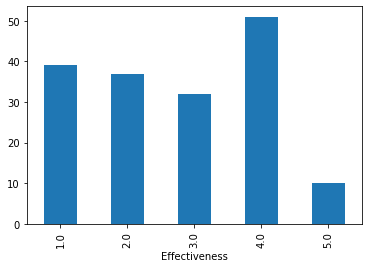

In [3]:
# visulaise dataset
def plot_data(label):
    data.groupby(label).VideoID.count().plot.bar(ylim=0)
    plt.show()
    
plot_data('Effectiveness')

In [4]:
# clean data
data = data.loc[(data["Effectiveness"] == 1) | (data["Effectiveness"] == 2) | (data["Effectiveness"] == 3) | (data["Effectiveness"] == 4) | (data["Effectiveness"] == 5)]
data = data.reset_index()
del data["index"]
data

VideoID  Effectiveness
0    pvuN_WvF1to            1.0
1    eRLJscAlk1M            5.0
2    VbiRNT_gWUQ            2.0
3    5scez5dqtAc            4.0
4    JDcro7dPqpA            2.0
..           ...            ...
164  TZ0j6kr4ZJ0            3.0
165  8DiWzvE52ZY            1.0
166  OwqIy8Ikv-c            2.0
167  lPgZfhnCAdI            1.0
168  dSu5sXmsur4            3.0

[169 rows x 2 columns]

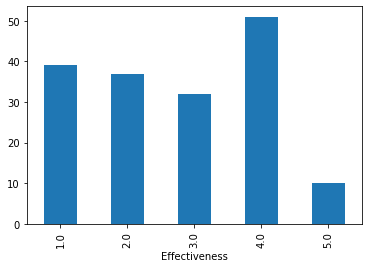

In [5]:
# visulaise 
plot_data('Effectiveness')

In [6]:
## Custom encoder
def custom_encoder(df):
    df.replace(to_replace = 1.0, value = "neg", inplace=True)
    df.replace(to_replace = 2.0, value = "neg", inplace=True)
    df.replace(to_replace = 4.0, value = "pos", inplace=True)
    df.replace(to_replace = 5.0, value = "pos", inplace=True)

custom_encoder(df['Effectiveness'])

data = df[["VideoID", "Effectiveness"]]
data = data[data["Effectiveness"] != 3]
data = data.loc[(data["Effectiveness"] == 'pos') | (data["Effectiveness"] == 'neg')]
data = data.reset_index()
del data["index"]
data

VideoID Effectiveness
0    pvuN_WvF1to           neg
1    eRLJscAlk1M           pos
2    VbiRNT_gWUQ           neg
3    5scez5dqtAc           pos
4    JDcro7dPqpA           neg
..           ...           ...
132  JYZpxRy5Mfg           pos
133  xXMlFFY9uEI           pos
134  8DiWzvE52ZY           neg
135  OwqIy8Ikv-c           neg
136  lPgZfhnCAdI           neg

[137 rows x 2 columns]

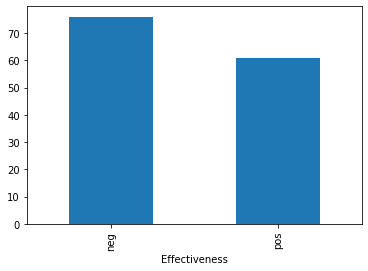

In [7]:
# visulaise 
plot_data('Effectiveness')

In [8]:
# get documnets (pre-processd comments)
documents = []
for i in range(len(data)):
    VideoID = data["VideoID"][i]
    comment = pd.read_csv("../../NLP Preprocessing/03_Processed_Comments/"+VideoID+"/"+VideoID+"_all_words.csv")
    documents.append(list(comment["0"]))

In [9]:
# create two new columns of the pre-processed data in list and string form
data['cleaned'] = documents
data['cleaned_string'] = [' '.join(map(str, l)) for l in data['cleaned']]

# Additional Features

In [10]:
## Create more features

# functions for feature creation
def words_count(text):
    return len(text.split())

def sent_count(text):
    return len(nltk.sent_tokenize(text))

def punct_count(text):
    cnt = 0
    for i in punctuation:
        cnt = cnt + text.count(i)
    return cnt

def emoji_count(text):
    emojis_iter = map(lambda y: y, emoji.UNICODE_EMOJI['en'].keys())
    regex_set = re.compile('|'.join(re.escape(em) for em in emojis_iter))
    new_list = regex_set.findall(text)
    return len(new_list)

def average(lst):
    return sum(lst) / len(lst)

In [11]:
# function to create a new feature
def new_feature(fun):
    ave = []
    for i in range(len(data)):
        VideoID = data["VideoID"][i]
        print(i)
        video = pd.read_json("../../NLP Preprocessing/01_Comments/"+VideoID+".json", lines=True)
        comments = video["text"]
        feature_lengths = []
        for comment in comments:
            feature_lengths.append(fun(comment))
        ave.append(average(feature_lengths))
    return ave

In [12]:
## load pickles ##
average_word_length_f = open('pickles/average_word_length.pickle', "rb")
average_word_length = pickle.load(average_word_length_f)
average_word_length_f.close()

average_sent_length_f = open('pickles/average_sent_length.pickle', "rb")
average_sent_length = pickle.load(average_sent_length_f)
average_sent_length_f.close()

average_punctuation_count_f = open('pickles/average_punctuation_count.pickle', "rb")
average_punctuation_count = pickle.load(average_punctuation_count_f)
average_punctuation_count_f.close()

average_emoji_count_f = open('pickles/average_emoji_count.pickle', "rb")
average_emoji_count = pickle.load(average_emoji_count_f)
average_emoji_count_f.close()

In [13]:
## Sentiment features
def average_sentiment():
    ave = []
    for i in range(len(data)):
        VideoID = data["VideoID"][i]
        print(i)
        video = pd.read_json("../../NLP Preprocessing/03_Processed_Comments/"+VideoID+"/"+VideoID+".json", lines=True)
        sentiments = video["sentiment"]
        sentiment_strengths = []
        for sentiment in sentiments:
            sentiment_strengths.append(sentiment)
        ave.append(average(sentiment_strengths))
    return ave

def neg_neu_pos(lst):
    neg_count, neu_count, pos_count = (0,)*3 
    for sentiment in lst:
        if sentiment < 0:
            neg_count += 1
        if sentiment == 0:
            neu_count += 1
        if sentiment > 0:
            pos_count += 1
    return neg_count, neu_count, pos_count

def ratio(count,video):
    return count/len(video)

def sentiment_ratio():
    sentiment_ratios_neg, sentiment_ratios_neu, sentiment_ratios_pos = [],[],[]
    for i in range(len(data)):
        VideoID = data["VideoID"][i]
        print(i)
        video = pd.read_json("../../NLP Preprocessing/03_Processed_Comments/"+VideoID+"/"+VideoID+".json", lines=True)
        sentiments = video["sentiment"]
        neg_count, neu_count, pos_count = neg_neu_pos(sentiments)
        sentiment_ratios_neg.append(ratio(neg_count,video))
        sentiment_ratios_neu.append(ratio(neu_count,video))
        sentiment_ratios_pos.append(ratio(pos_count,video))
    return sentiment_ratios_neg, sentiment_ratios_neu, sentiment_ratios_pos

In [14]:
## load pickles ##
ave_sentiment_f = open('pickles/ave_sentiment.pickle', "rb")
ave_sentiment = pickle.load(ave_sentiment_f)
ave_sentiment_f.close()

sentiment_ratios_neg_f = open('pickles/sentiment_ratios_neg.pickle', "rb")
sentiment_ratios_neg = pickle.load(sentiment_ratios_neg_f)
sentiment_ratios_neg_f.close()

sentiment_ratios_neu_f = open('pickles/sentiment_ratios_neu.pickle', "rb")
sentiment_ratios_neu = pickle.load(sentiment_ratios_neu_f)
sentiment_ratios_neu_f.close()

sentiment_ratios_pos_f = open('pickles/sentiment_ratios_pos.pickle', "rb")
sentiment_ratios_pos = pickle.load(sentiment_ratios_pos_f)
sentiment_ratios_pos_f.close()

In [15]:
num_comments = []
videoIDs = data["VideoID"]

for videoID in videoIDs:
    video = pd.read_json("../../NLP Preprocessing/01_Comments/"+videoID+".json", lines=True)
    num_comments.append(len(video))

In [16]:
data["num_comments"] = num_comments
data["average_word_length"] = average_word_length
data["average_sentence_length"] = average_sent_length
data["average_punctuation_count"] = average_punctuation_count
data["average_emoji_count"] = average_emoji_count
data["average_sentiment"] = ave_sentiment
data["sentiment_ratio_negative"] = sentiment_ratios_neg
data["sentiment_ratio_neutral"] = sentiment_ratios_neu
data["sentiment_ratio_positive"] = sentiment_ratios_pos
data

VideoID Effectiveness  \
0    pvuN_WvF1to           neg   
1    eRLJscAlk1M           pos   
2    VbiRNT_gWUQ           neg   
3    5scez5dqtAc           pos   
4    JDcro7dPqpA           neg   
..           ...           ...   
132  JYZpxRy5Mfg           pos   
133  xXMlFFY9uEI           pos   
134  8DiWzvE52ZY           neg   
135  OwqIy8Ikv-c           neg   
136  lPgZfhnCAdI           neg   

                                               cleaned  \
0    [clean, version, video, child, love, northeast...   
1    [step, take, help, fight, climate, change, wel...   
2    [country, disappear, video, year, old, world, ...   
3    [im, watch, trump, biden, ha, already, start, ...   
4    [fun, fact, cow, belch, fart, adult, version, ...   
..                                                 ...   
132  [usually, consumer_NEG, say_NEG, though_NEG, s...   
133  [joe, biden, ha, plan, fix, thing, forefront, ...   
134  [marios, leave, hand, doe, intro, impressive, ...   
135  [lie, interseting, isnt, group_NEG, consist_NE...   
136  [miss, man, wa, hero, didnt, cherish_NEG, enou...   

                                        cleaned_string  num_comments  \
0    clean version video child love northeast india...        125533   
1    step take help fight climate change well equal...        161953   
2    country disappear video year old world map did...         27616   
3    im watch trump biden ha already start process ...         13773   
4    fun fact cow belch fart adult version bill nye...         18821   
..                                                 ...           ...   
132  usually consumer_NEG say_NEG though_NEG suppor...           415   
133  joe biden ha plan fix thing forefront news sev...           431   
134  marios leave hand doe intro impressive today p...          5262   
135  lie interseting isnt group_NEG consist_NEG com...         14421   
136  miss man wa hero didnt cherish_NEG enough_NEG ...          3777   

     average_word_length  average_sentence_length  average_punctuation_count  \
0              11.370739                 1.292959                   2.123577   
1              17.195229                 1.594994                   2.718289   
2              18.386660                 1.726789                   3.540701   
3              32.300443                 2.364554                   5.870616   
4              34.869454                 2.559588                   6.624250   
..                   ...                      ...                        ...   
132            19.036145                 1.759036                   3.508434   
133            37.774942                 2.700696                   9.039443   
134            18.298556                 1.779742                   3.726720   
135            57.651203                 3.803966                  13.288954   
136            40.999735                 3.014562                   8.415674   

     average_emoji_count  average_sentiment  sentiment_ratio_negative  \
0               0.588371           0.095633                  0.137295   
1               0.489704           0.037611                  0.202355   
2               0.117903           0.052846                  0.196010   
3               0.060626           0.020608                  0.301387   
4               0.106902           0.032238                  0.296796   
..                   ...                ...                       ...   
132             0.207229           0.090164                  0.149398   
133             0.153132           0.034621                  0.225058   
134             0.136640           0.143438                  0.129609   
135             0.029402           0.049250                  0.249983   
136             0.034948           0.017825                  0.294943   

     sentiment_ratio_neutral  sentiment_ratio_positive  
0                   0.529606                  0.333100  
1                   0.500905                  0.296740  
2                   0.445177 

# Classifiers with Feature Engineering

In [17]:
# Using TF-IDF
vectorizer = TfidfVectorizer(min_df=1)
final_features = vectorizer.fit_transform(data['cleaned_string']).toarray()

In [18]:
final = pd.DataFrame(final_features)

In [19]:
#lListing all features
features = ['average_word_length', 'average_sentence_length', 'average_punctuation_count',
           'average_emoji_count', 'average_sentiment', 'sentiment_ratio_negative',
           'sentiment_ratio_neutral', 'sentiment_ratio_positive']

In [20]:
# merging all features with the above TF-IDF. 
ff = pd.merge(final,data[features],left_index=True, right_index=True)
ff

0         1         2         3         4         5         6  \
0    0.000259  0.000000  0.000315  0.000000  0.000435  0.000000  0.000372   
1    0.000473  0.000053  0.000222  0.000000  0.000000  0.000084  0.000000   
2    0.000201  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.000539  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.000181  0.000263  0.000000  0.000258  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
132  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
133  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
134  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
135  0.000000  0.000225  0.000379  0.000883  0.000000  0.000000  0.000000   
136  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            7         8         9  ...  569679  569680  average_word_length  \
0    0.000237  0.000085  0.000149  ...     0.0     0.0            11.370739   
1    0.000067  0.000000  0.000000  ...     0.0     0.0            17.195229   
2    0.000000  0.000397  0.000000  ...     0.0     0.0            18.386660   
3    0.000000  0.000000  0.000000  ...     0.0     0.0            32.300443   
4    0.000000  0.000000  0.000000  ...     0.0     0.0            34.869454   
..        ...       ...       ...  ...     ...     ...                  ...   
132  0.000000  0.000000  0.000000  ...     0.0     0.0            19.036145   
133  0.000000  0.000000  0.000000  ...     0.0     0.0            37.774942   
134  0.000000  0.000000  0.000000  ...     0.0     0.0            18.298556   
135  0.000000  0.000000  0.000000  ...     0.0     0.0            57.651203   
136  0.000000  0.000000  0.000000  ...     0.0     0.0            40.999735   

     average_sentence_length  average_punctuation_count  average_emoji_count  \
0                   1.292959                   2.123577             0.588371   
1                   1.594994                   2.718289             0.489704   
2                   1.726789                   3.540701             0.117903   
3                   2.364554                   5.870616             0.060626   
4                   2.559588                   6.624250             0.106902   
..                       ...                        ...                  ...   
132                 1.759036                   3.508434             0.207229   
133                 2.700696                   9.039443             0.153132   
134                 1.779742                   3.726720             0.136640   
135                 3.803966                  13.288954             0.029402   
136                 3.014562                   8.415674             0.034948   

     average_sentiment  sentiment_ratio_negative  sentiment_ratio_neutral  \
0             0.095633                  0.137295                 0.529606   
1             0.037611                  0.202355                 0.500905   
2             0.052846                  0.196010                 0.445177   
3             0.020608                  0.301387                 0.315545   
4             0.032238                  0.296796                 0.313480   
..                 ...                       ...                      ...   
132           0.090164                  0.149398                 0.513253   
133           0.034621                  0.225058                 0.396752   
134           0.143438                  0.129609                 0.403079   
135           0.049250                  0.249983                 0.278275   
136           0.017825                  0.294943                 0.291236   

     sentiment_ratio_positive  
0                    0.333100  
1                    0.296740  
2                    0.358814  
3                    0.383068  
4                    0.389724  
..                        ...  
132                  0.33734

In [21]:
# first split the dataset into testing and training set:
# this block is to split the dataset into training and testing set 
X = ff
y = data['Effectiveness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [22]:
# Logistic Regression
pipeline = Pipeline([('clf', LogisticRegression(n_jobs=1, C=1e5))])

LRC = pipeline.fit(X_train, y_train)

ytest = np.array(y_test)
LRC_prediction =  LRC.predict(X_test)

print("Accuracy => ", round(accuracy_score(LRC_prediction, ytest)*100, 2))
print("\nLogistic Regression Classifier results: \n")
print(classification_report(ytest, LRC_prediction))

C:\Users\Jared\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy =>  69.05

Logistic Regression Classifier results: 

              precision    recall  f1-score   support

         neg       0.70      0.73      0.71        22
         pos       0.68      0.65      0.67        20

    accuracy                           0.69        42
   macro avg       0.69      0.69      0.69        42
weighted avg       0.69      0.69      0.69        42



In [23]:
# SGD
SGD = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

SGD.fit(X_train, y_train)
SGD_prediction = SGD.predict(X_test)

print("Accuracy => ", round(accuracy_score(SGD_prediction, y_test)*100, 2))
print("\nSGD Classifier results: \n")
print(classification_report(y_test, SGD_prediction))

Accuracy =>  52.38

SGD Classifier results: 

              precision    recall  f1-score   support

         neg       0.52      1.00      0.69        22
         pos       0.00      0.00      0.00        20

    accuracy                           0.52        42
   macro avg       0.26      0.50      0.34        42
weighted avg       0.27      0.52      0.36        42



C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# LinearSVC
LSVC = LinearSVC()

LSVC.fit(X_train, y_train)
LSVC_prediction = LSVC.predict(X_test)

print("Accuracy => ", round(accuracy_score(LSVC_prediction, y_test)*100, 2))
print("\nLinearSVC results: \n")
print(classification_report(y_test, LSVC_prediction))

C:\Users\Jared\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy =>  59.52

LinearSVC results: 

              precision    recall  f1-score   support

         neg       0.58      0.82      0.68        22
         pos       0.64      0.35      0.45        20

    accuracy                           0.60        42
   macro avg       0.61      0.58      0.57        42
weighted avg       0.61      0.60      0.57        42



In [25]:
# Random Forest
RFC = RandomForestClassifier(n_estimators = 1000, min_samples_split = 15, random_state = 42)

RFC.fit(X_train, y_train)
RFC_prediction = RFC.predict(X_test)

print("Accuracy => ", round(accuracy_score(RFC_prediction, y_test)*100, 2))
print("\nRandom Forest Classifier results: \n")
print(classification_report(y_test, RFC_prediction))

Accuracy =>  69.05

Random Forest Classifier results: 

              precision    recall  f1-score   support

         neg       0.65      0.91      0.75        22
         pos       0.82      0.45      0.58        20

    accuracy                           0.69        42
   macro avg       0.73      0.68      0.67        42
weighted avg       0.73      0.69      0.67        42



# Classification without Feature Engineering

In [26]:
# function to plot confusion matrix
def plot_conf_matrix(conf_matrix):
    group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

In [27]:
# set vectorizer
vectorizer = TfidfVectorizer(min_df=3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 1))

# split training and test set
X = data.cleaned_string
y = data.Effectiveness
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         neg       0.52      1.00      0.69        22
         pos       0.00      0.00      0.00        20

    accuracy                           0.52        42
   macro avg       0.26      0.50      0.34        42
weighted avg       0.27      0.52      0.36        42



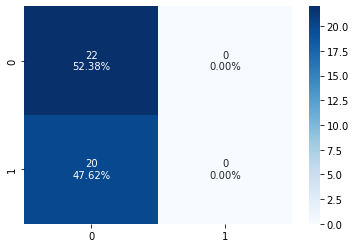

In [28]:
## Multinomial Naive Bayes Classifier
MNB = Pipeline([('vect', vectorizer),
               ('clf', MultinomialNB()),
              ])

MNB.fit(X_train, y_train)

y_pred_MNB = MNB.predict(X_test)

print(classification_report(y_test, y_pred_MNB))

# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_MNB)
plot_conf_matrix(conf_matrix)

              precision    recall  f1-score   support

         neg       0.71      0.68      0.70        22
         pos       0.67      0.70      0.68        20

    accuracy                           0.69        42
   macro avg       0.69      0.69      0.69        42
weighted avg       0.69      0.69      0.69        42



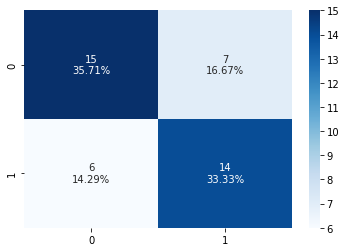

In [29]:
## Bernoulli Naive Bayes Classifier
BNB = Pipeline([('vect', TfidfVectorizer(min_df=6)),
               ('clf', BernoulliNB()),
              ])

BNB_train = BNB.fit(X_train, y_train)

y_pred_BNB = BNB_train.predict(X_test)

print(classification_report(y_test, y_pred_BNB))

# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_BNB)
plot_conf_matrix(conf_matrix)

              precision    recall  f1-score   support

         neg       0.76      0.73      0.74        22
         pos       0.71      0.75      0.73        20

    accuracy                           0.74        42
   macro avg       0.74      0.74      0.74        42
weighted avg       0.74      0.74      0.74        42



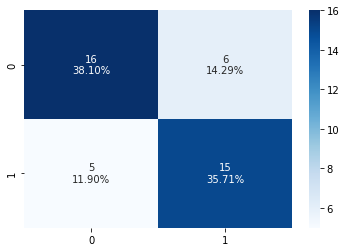

In [30]:
## Stochastic Gradient Descent Classifier 
SGD = Pipeline([('vect', vectorizer),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, tol=None, random_state=12)),
               ])

SGD_train = SGD.fit(X_train, y_train)

y_pred_SGD = SGD_train.predict(X_test)

print(classification_report(y_test, y_pred_SGD))
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_SGD)
plot_conf_matrix(conf_matrix)

              precision    recall  f1-score   support

         neg       0.78      0.82      0.80        22
         pos       0.79      0.75      0.77        20

    accuracy                           0.79        42
   macro avg       0.79      0.78      0.78        42
weighted avg       0.79      0.79      0.79        42



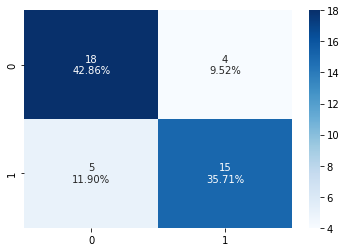

In [31]:
## Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', vectorizer),
                   ('clf', LogisticRegression(n_jobs=1, C=100000.0, penalty='l1', solver='liblinear', random_state=12)),
                  ])

logreg_train = logreg.fit(X_train, y_train)

y_pred_logreg = logreg_train.predict(X_test)

print(classification_report(y_test, y_pred_logreg))
# plot confusion matrix
plot_conf_matrix(confusion_matrix(y_test, y_pred_logreg))

              precision    recall  f1-score   support

         neg       0.53      0.73      0.62        22
         pos       0.50      0.30      0.37        20

    accuracy                           0.52        42
   macro avg       0.52      0.51      0.50        42
weighted avg       0.52      0.52      0.50        42



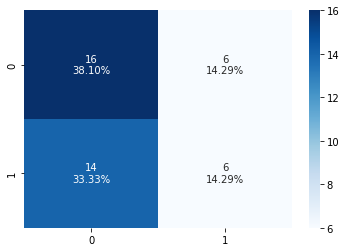

In [32]:
## Support Vector Classifier
svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC()),
               ])

svc.fit(X_train, y_train)

y_pred_SVC = svc.predict(X_test)

print(classification_report(y_test, y_pred_SVC))
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_SVC)
plot_conf_matrix(conf_matrix)

              precision    recall  f1-score   support

         neg       0.65      0.77      0.71        22
         pos       0.69      0.55      0.61        20

    accuracy                           0.67        42
   macro avg       0.67      0.66      0.66        42
weighted avg       0.67      0.67      0.66        42



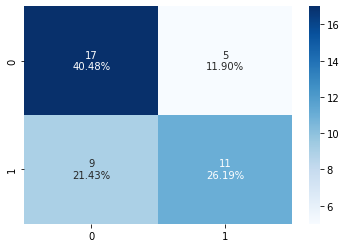

In [33]:
## Linear Support Vector Classifier
linear_svc = Pipeline([('vect', vectorizer),
                       ('clf', LinearSVC()),
                      ])

linear_svc.fit(X_train, y_train)

y_pred_LinearSVC = linear_svc.predict(X_test)

print(classification_report(y_test, y_pred_LinearSVC))
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_LinearSVC)
plot_conf_matrix(conf_matrix)

              precision    recall  f1-score   support

         neg       0.64      0.64      0.64        22
         pos       0.60      0.60      0.60        20

    accuracy                           0.62        42
   macro avg       0.62      0.62      0.62        42
weighted avg       0.62      0.62      0.62        42



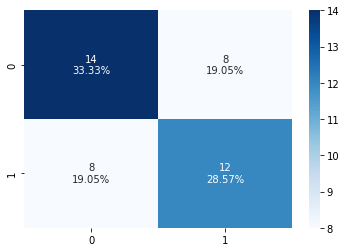

In [34]:
## Nu-Support Vector Classifier
Nu_svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', NuSVC()),
               ])

Nu_svc.fit(X_train, y_train)

y_pred_NuSVC = Nu_svc.predict(X_test)

print(classification_report(y_test, y_pred_NuSVC))
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_NuSVC)
plot_conf_matrix(conf_matrix)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

         neg       0.68      0.86      0.76        22
         pos       0.79      0.55      0.65        20

    accuracy                           0.71        42
   macro avg       0.73      0.71      0.70        42
weighted avg       0.73      0.71      0.71        42



[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.0s finished


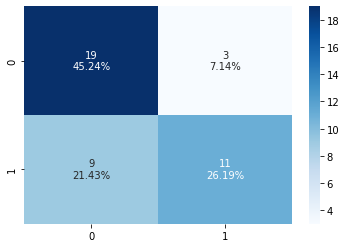

In [35]:
## Random Forest Classifier
randFor = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', RandomForestClassifier(n_estimators=1000, random_state=1, criterion='entropy', oob_score=True, verbose=1)),
                   ])

randFor_train = randFor.fit(X_train, y_train)

y_pred_RandFor = randFor_train.predict(X_test)

print(classification_report(y_test, y_pred_RandFor))
# plot confusion matrix
plot_conf_matrix(confusion_matrix(y_test, y_pred_RandFor))

## Boosting algorithms

C:\Users\Jared\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:19:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         neg       0.79      0.68      0.73        22
         pos       0.70      0.80      0.74        20

    accuracy                           0.74        42
   macro avg       0.74      0.74      0.74        42
weighted avg       0.74      0.74      0.74        42



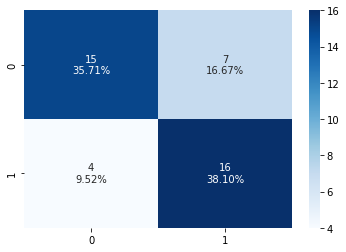

In [36]:
## XGBoost
XGB = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier()),
               ])

XGB_train = XGB.fit(X_train, y_train)

y_pred_XGB = XGB_train.predict(X_test)

print(classification_report(y_test, y_pred_XGB))
# plot confusion matrix
plot_conf_matrix(confusion_matrix(y_test, y_pred_XGB))

              precision    recall  f1-score   support

         neg       0.64      0.64      0.64        22
         pos       0.60      0.60      0.60        20

    accuracy                           0.62        42
   macro avg       0.62      0.62      0.62        42
weighted avg       0.62      0.62      0.62        42



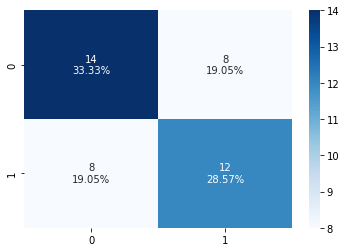

In [37]:
## AdaBoost
AdaBoost = Pipeline([('vect', vectorizer),
                     ('clf', AdaBoostClassifier()),
                    ])

AdaBoost.fit(X_train, y_train)

y_pred_AdaBoost = AdaBoost.predict(X_test)

print(classification_report(y_test, y_pred_AdaBoost))
# plot confusion matrix
plot_conf_matrix(confusion_matrix(y_test, y_pred_AdaBoost))

# Evaluate Algorithms

In [38]:
## Evaluate algorithms
def evaluate(y_test, y_pred_dict):
    table = pd.DataFrame({}, index=['Accuracy', 'Precision', 'Recall','F1-score']) 
    
    for model in y_pred_dict:
        report = classification_report(y_test, y_pred_dict[model], digits=2, output_dict=True)
        
        cols = [report['accuracy'],(report['neg']['precision']+report['pos']['precision'])/2,(report['neg']['recall']+report['pos']['recall'])/2,(report['neg']['f1-score']+report['pos']['f1-score'])/2]
        table[model] = cols
    
    # add CNN results
    table.insert(table.shape[1],"CNN", [0.8235,0.8888,0.6153,0.7272], True)
    
    # convert to percentage
    table = table*100
    
    # Add 'Best Score' column
    table['Best Score'] = table.idxmax(axis=1)
    
    return table.round(2)

In [39]:
# dictionary of algorithms and their respective predictions
y_pred_dict = {"Multinomial Naive Bayes": y_pred_MNB, 
               "Bernoulli Naive Bayes": y_pred_BNB,
               "SGD": y_pred_SGD, 
               "Logistic Regression": y_pred_logreg,
               "Support Vector Classifier": y_pred_SVC,
               "Linear Support Vector Classifier": y_pred_LinearSVC,
               "Nu-Support Vector Classifier": y_pred_NuSVC,
               "Random Forest": y_pred_RandFor,
               "XGBoost": y_pred_XGB,
               "AdaBoost Classifier": y_pred_AdaBoost
              }

table = evaluate(y_test, y_pred_dict)
table

C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jared\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Multinomial Naive Bayes  Bernoulli Naive Bayes    SGD  \
Accuracy                     52.38                  69.05  73.81   
Precision                    26.19                  69.05  73.81   
Recall                       50.00                  69.09  73.86   
F1-score                     34.38                  69.03  73.79   

           Logistic Regression  Support Vector Classifier  \
Accuracy                 78.57                      52.38   
Precision                78.60                      51.67   
Recall                   78.41                      51.36   
F1-score                 78.46                      49.52   

           Linear Support Vector Classifier  Nu-Support Vector Classifier  \
Accuracy                              66.67                         61.90   
Precision                             67.07                         61.82   
Recall                                66.14                         61.82   
F1-score                              65.97                         61.82   

           Random Forest  XGBoost  AdaBoost Classifier    CNN  \
Accuracy           71.43    73.81                61.90  82.35   
Precision          73.21    74.26                61.82  88.88   
Recall             70.68    74.09                61.82  61.53   
F1-score           70.35    73.79                61.82  72.72   

                    Best Score  
Accuracy                   CNN  
Precision                  CNN  
Recall     Logistic Regression  
F1-score   Logistic Regression

C:\Users\Jared\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


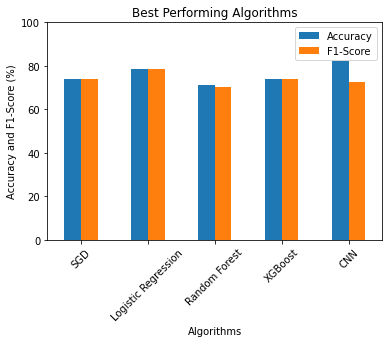

In [40]:
## Plot
# get only accuracy and F1-score
accuracy_f1 = table.iloc[[0,3]]
accuracy_f1.drop(accuracy_f1.columns[len(accuracy_f1.columns)-1], axis=1, inplace=True)
# get all algoritms with accuracy >= 70
accuracy_f1 = accuracy_f1.loc[:, accuracy_f1.gt(70).any()]

# convert numpy array into list
accuracy_values = [item for sublist in accuracy_f1.iloc[[0]].values.tolist() for item in sublist]
f1_values = [item for sublist in accuracy_f1.iloc[[1]].values.tolist() for item in sublist]

plotdata = pd.DataFrame({
    "Accuracy" : accuracy_values,
    "F1-Score" : f1_values
    }, 
    index = list(accuracy_f1)
)
plotdata.plot(kind="bar")   

plt.title("Best Performing Algorithms")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy and F1-Score (%)")
plt.xticks(rotation=45, ha="center")
plt.ylim([0,100])
plt.legend(loc='best')
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]    
#plt.savefig('Best Performing Algorithms.png', bbox_inches = "tight")